[![Colab Badge](http://img.shields.io/badge/Colaboratory-black?style=for-the-badge&logo=google-colab)](https://colab.research.google.com/github/TINYML-KOR/assignment/blob/main/Lab1_castleflag.ipynb)

# **MIT 6.5940 EfficientML.ai Fall 2023: Lab 1 Pruning**


This colab notebook provides code and a framework for ***Lab 1 Pruning***. You can work out your solutions here.



Please fill out this [feedback form](https://forms.gle/fapEmEUYr3WnXjBU8) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

## Goals

- **pruning**Ïùò Í∏∞Î≥∏ Í∞úÎÖêÏùÑ Ïù¥Ìï¥Ìï©ÎãàÎã§.
- **fine-grained pruning**ÏùÑ Íµ¨ÌòÑÌïòÍ≥† Ï†ÅÏö©Ìï©ÎãàÎã§.
- **channel pruning**ÏùÑ Íµ¨ÌòÑÌïòÍ≥† Ï†ÅÏö©Ìï©ÎãàÎã§.
- pruningÏúºÎ°úÎ∂ÄÌÑ∞Ïùò ÏÑ±Îä• Í∞úÏÑ†(Ïòà: ÏÜçÎèÑ Ìñ•ÏÉÅ)Ïóê ÎåÄÌïú Í∏∞Î≥∏Ï†ÅÏù∏ Ïù¥Ìï¥Î•º ÏñªÏäµÎãàÎã§.
- Ïù¥Îü¨Ìïú pruning Ï†ëÍ∑º Î∞©Ïãù Í∞ÑÏùò Ï∞®Ïù¥Ï†êÍ≥º tradeoffsÎ•º Ïù¥Ìï¥Ìï©ÎãàÎã§.

## Contents

There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

There are ***9*** questions in total:
- For *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For *Channel Pruning*, there are ***3*** questions (Question 6-8).
- Question 9 compares fine-grained pruning and channel pruning.


Ïù¥ Ïã§ÏäµÏóêÎäî ***Fine-grained Pruning***Í≥º ***Channel Pruning***Ïùò Îëê Í∞ÄÏßÄ Ï£ºÏöî ÏÑπÏÖòÏù¥ ÏûàÏäµÎãàÎã§.

Ï¥ù ***9***Í∞úÏùò ÏßàÎ¨∏Ïù¥ ÏûàÏäµÎãàÎã§:
- *Fine-grained Pruning*Ïóê ÎåÄÌï¥ÏÑúÎäî ***5***Í∞úÏùò ÏßàÎ¨∏Ïù¥ ÏûàÏäµÎãàÎã§ (Question 1-5).
- *Channel Pruning*Ïóê ÎåÄÌï¥ÏÑúÎäî ***3***Í∞úÏùò ÏßàÎ¨∏Ïù¥ ÏûàÏäµÎãàÎã§ (Question 6-8).
- Question 9Îäî **fine-grained pruning**Í≥º **channel pruning**ÏùÑ ÎπÑÍµêÌï©ÎãàÎã§.

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [35]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [36]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [37]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [38]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [39]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [40]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [41]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [42]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [43]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [44]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [45]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Î®ºÏ†Ä Dense ModelÏùò Ï†ïÌôïÎèÑÏôÄ Î™®Îç∏ ÌÅ¨Í∏∞Î•º ÌôïÏù∏Ìï¥Î¥ÖÏãúÎã§

Neural networksÎäî ÎßéÏùÄ ÏùëÏö© ÌîÑÎ°úÍ∑∏Îû®ÏóêÏÑú ÏÇ¨Ïö©ÎêòÍ≥† ÏûàÏäµÎãàÎã§. Ïó¨Í∏∞ÏÑúÎäî CIFAR10 Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ïù¥ÎØ∏ÏßÄÎ•º Î∂ÑÎ•òÌïòÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú VGG Î™®Îç∏ÏùÑ Î°úÎìúÌñàÏäµÎãàÎã§.

Î®ºÏ†Ä Ïù¥ Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÏôÄ Î™®Îç∏ ÌÅ¨Í∏∞Î•º ÌôïÏù∏Ìï¥Î¥ÖÏãúÎã§.


In [48]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


ÌÅ∞ neural networksÎäî Îß§Ïö∞ Í∞ïÎ†•ÌïòÏßÄÎßå, Í∑∏ ÌÅ¨Í∏∞Îäî ÏÉÅÎãπÌïú Ï†ÄÏû• Í≥µÍ∞Ñ, Î©îÎ™®Î¶¨ ÎåÄÏó≠Ìè≠, Í∑∏Î¶¨Í≥† Í≥ÑÏÇ∞ ÏûêÏõêÏùÑ ÏÜåÎπÑÌï©ÎãàÎã§.
ÏúÑÏùò Í≤∞Í≥ºÏóêÏÑú Î≥º Ïàò ÏûàÎìØÏù¥, $32\times32$ Ïù¥ÎØ∏ÏßÄÎ•º 10Í∞ú ÌÅ¥ÎûòÏä§Î°ú Î∂ÑÎ•òÌïòÎäî Í≤ÉÍ≥º Í∞ôÏù¥ Í∞ÑÎã®Ìïú ÏûëÏóÖÏùÑ ÏúÑÌïú Î™®Îç∏Ï°∞Ï∞®ÎèÑ 35 MiB Ïö©ÎüâÏùÑ Í∞ÄÏßëÎãàÎã§.
ÏûÑÎ≤†ÎîîÎìú Î™®Î∞îÏùº ÏùëÏö© ÌîÑÎ°úÍ∑∏Îû®Ïùò Í≤ΩÏö∞, Ïù¥Îü¨Ìïú ÏûêÏõê ÏöîÍµ¨ ÏÇ¨Ìï≠ÏùÄ ÌîºÌï¥Ïïº Ìï©ÎãàÎã§.


Îî∞ÎùºÏÑú, **neural network pruning**ÏùÄ DNNÏùÑ Ìè¨Ìï®Ìïú Î™®Î∞îÏùº ÏùëÏö© ÌîÑÎ°úÍ∑∏Îû®Ïùò Ï†ÄÏû• Î∞è Ï†ÑÏÜ°ÏùÑ Ïö©Ïù¥ÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Ïì∞ÏûÖÎãàÎã§.

pruningÏùò Î™©ÌëúÎäî **Ï†ïÌôïÎèÑÎ•º Ïú†ÏßÄÌïòÎ©¥ÏÑú Î™®Îç∏ ÌÅ¨Í∏∞Î•º Ï§ÑÏù¥Îäî Í≤É**ÏûÖÎãàÎã§.


# weight Í∞íÏùò Î∂ÑÌè¨Î•º ÏÇ¥Ìé¥Î¥ÖÏãúÎã§.


pruningÏúºÎ°ú ÎÑòÏñ¥Í∞ÄÍ∏∞ Ï†ÑÏóê, dense Î™®Îç∏ÏóêÏÑú Í∞ÄÏ§ëÏπò Í∞íÏùò Î∂ÑÌè¨Î•º ÏÇ¥Ìé¥Î¥ÖÏãúÎã§.

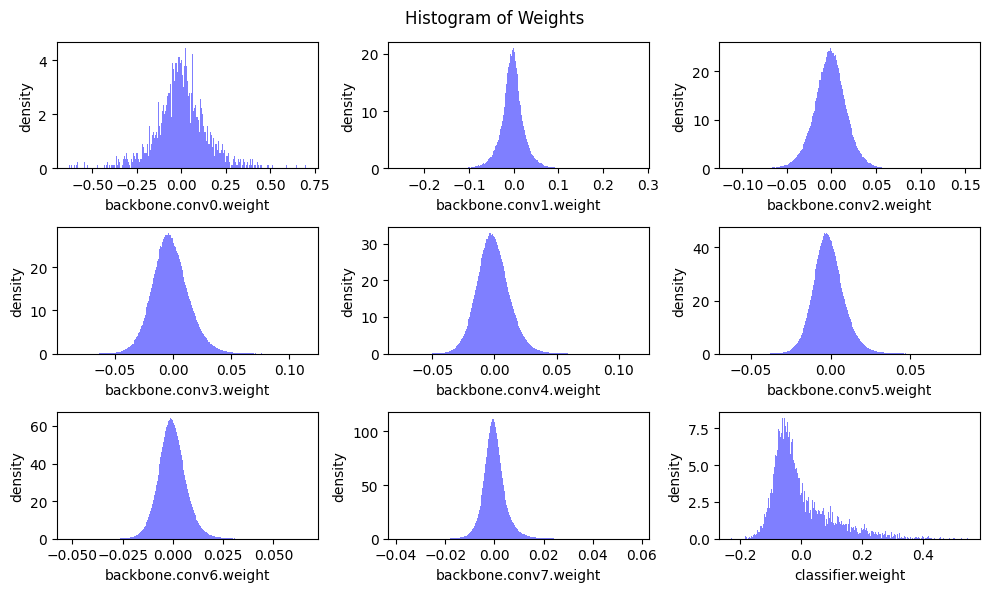

In [49]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## Question 1 (10 pts)

ÏúÑ weight ÌûàÏä§ÌÜ†Í∑∏Îû®Îì§ÏùÑ Î≥¥Í≥† Îã§Ïùå ÏßàÎ¨∏Ïóê ÎãµÌï¥ Ï£ºÏÑ∏Ïöî.


### Question 1.1 (5 pts)

Í∞ÅÍ∏∞ Îã§Î•∏ Í≥ÑÏ∏µÏóêÏÑú weight Î∂ÑÌè¨Îì§Ïùò Í≥µÌÜµÏ†ÅÏù∏ ÌäπÏÑ±ÏùÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?


**Your Answer:**

meanÏù¥ 0Ïù∏ normal Î∂ÑÌè¨Î•º Îî∞Î•¥Í≥† ÏûàÎã§ (backboneÏùò Í≤ΩÏö∞, classifier Ï†úÏô∏)

### Question 1.2  (5 pts)

Ïù¥Îü¨Ìïú ÌäπÏÑ±Îì§Ïù¥ pruningÏóê Ïñ¥ÎñªÍ≤å ÎèÑÏõÄÏù¥ ÎêòÎÇòÏöî?


**Your Answer:**


0Ïù¥ ÎßéÏúºÎØÄÎ°ú, Í≥ÑÏÇ∞ÌïòÏßÄ ÏïäÍ±∞ÎÇò ÏóÜÏï® Ïàò ÏûàÎã§.

# Fine-grained Pruning

Ïù¥ ÏÑπÏÖòÏóêÏÑúÎäî **fine-grained pruning**ÏùÑ Íµ¨ÌòÑÌïòÍ≥† ÏàòÌñâÌï† Í≤ÉÏûÖÎãàÎã§.

Fine-grained pruningÏùÄ Í∞ÄÏû• Ï§ëÏöîÎèÑÍ∞Ä ÎÇÆÏùÄ synapsesÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§. Fine-grained pruning ÌõÑÏóêÎäî Í∞ÄÏ§ëÏπò ÌÖêÏÑú $W$Í∞Ä sparseÌï¥ÏßÄÎ©∞, Ïù¥Îäî **sparsity**Î°ú ÏÑ§Î™ÖÌï† Ïàò ÏûàÏäµÎãàÎã§:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

Ïó¨Í∏∞ÏÑú $\#W$Îäî $W$Ïùò element ÏàòÏûÖÎãàÎã§.

Ïã§Ï†úÎ°ú, Î™©Ìëú sparsity $s$Í∞Ä Ï£ºÏñ¥ÏßÄÎ©¥, Í∞ÄÏ§ëÏπò ÌÖêÏÑú $W$Îäî Ï†úÍ±∞Îêú Í∞ÄÏ§ëÏπòÎ•º Î¨¥ÏãúÌïòÍ∏∞ ÏúÑÌï¥ Ïù¥ÏßÑ ÎßàÏä§ÌÅ¨ $M$Í≥º Í≥±Ìï¥ÏßëÎãàÎã§:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

Ïó¨Í∏∞ÏÑú $Importance$Îäî $W$ÏôÄ ÎèôÏùºÌïú ÌòïÌÉúÏùò Ï§ëÏöîÎèÑ ÌÖêÏÑúÏù¥Î©∞, $\texttt{kthvalue}(X, k)$Îäî ÌÖêÏÑú $X$Ïùò $k$Î≤àÏß∏Î°ú ÏûëÏùÄ Í∞íÏùÑ Ï∞æÏúºÎ©∞, $v_{\mathrm{thr}}$Îäî ÏûÑÍ≥ÑÍ∞íÏûÖÎãàÎã§.


## Magnitude-based Pruning

Fine-grained pruningÏóê ÏûàÏñ¥ÏÑú ÎÑêÎ¶¨ ÏÇ¨Ïö©ÎêòÎäî importance(Ï§ëÏöîÎèÑ)Îäî weight Í∞íÏùò ÌÅ¨Í∏∞, Ï¶â,

$Importance=|W|$

ÏûÖÎãàÎã§. **Magnitude-based Pruning**ÏúºÎ°ú ÏïåÎ†§Ï†∏ ÏûàÏäµÎãàÎã§ ([Learning both Weights and Connections for Efficient Neural Networks](https://arxiv.org/pdf/1506.02626.pdf) Ï∞∏Ï°∞).


![](https://github.com/TINYML-KOR/assignment/blob/main/images/lab1/pruning.png?raw=1)

### Question 2 (15 pts)

Îã§Ïùå magnitude-based fine-grained pruning Ìï®ÏàòÎ•º ÏôÑÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî.

**Hint**:
*   1Îã®Í≥ÑÏóêÏÑúÎäî pruning ÌõÑÏóê 0Ïùò Í∞úÏàò(`num_zeros`)Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. `num_zeros`Îäî Ï†ïÏàòÏó¨Ïïº Ìï©ÎãàÎã§. Î∂ÄÎèô ÏÜåÏàòÏ†ê Ïà´ÏûêÎ•º Ï†ïÏàòÎ°ú Î≥ÄÌôòÌïòÍ∏∞ ÏúÑÌï¥ `round()` ÎòêÎäî `int()`Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïó¨Í∏∞ÏÑúÎäî `round()`Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
*   2Îã®Í≥ÑÏóêÏÑúÎäî Í∞ÄÏ§ëÏπò ÌÖêÏÑúÏùò `importance`Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. PytorchÎäî [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIÎ•º Ï†úÍ≥µÌï©ÎãàÎã§.
*   3Îã®Í≥ÑÏóêÏÑúÎäî `threshold`Î•º Í≥ÑÏÇ∞ÌïòÏó¨ `threshold`Î≥¥Îã§ Ï§ëÏöîÎèÑÍ∞Ä ÎÇÆÏùÄ Î™®Îì† synapsesÍ∞Ä Ï†úÍ±∞ÎêòÎèÑÎ°ù Ìï©ÎãàÎã§. PytorchÎäî [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIÎ•º Ï†úÍ≥µÌï©ÎãàÎã§.
*   4Îã®Í≥ÑÏóêÏÑúÎäî `threshold`Î•º Í∏∞Î∞òÏúºÎ°ú pruning `mask`Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. `mask`ÏóêÏÑú **1**ÏùÄ synapseÍ∞Ä Ïú†ÏßÄÎê®ÏùÑ ÎÇòÌÉÄÎÇ¥Í≥†, **0**ÏùÄ synapseÍ∞Ä Ï†úÍ±∞Îê®ÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. `mask = importance > threshold`. PytorchÎäî [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) APIÎ•º Ï†úÍ≥µÌï©ÎãàÎã§.


In [50]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(torch.flatten(importance), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold

    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

ÏúÑÏóêÏÑú Ï†ïÏùòÌïú fine-grained pruning Í∏∞Îä•ÏùÑ ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌï¥, ÎçîÎØ∏ ÌÖêÏÑúÏóê ÏúÑ Ìï®ÏàòÎ•º Ï†ÅÏö©Ìï¥ Î¥ÖÏãúÎã§.

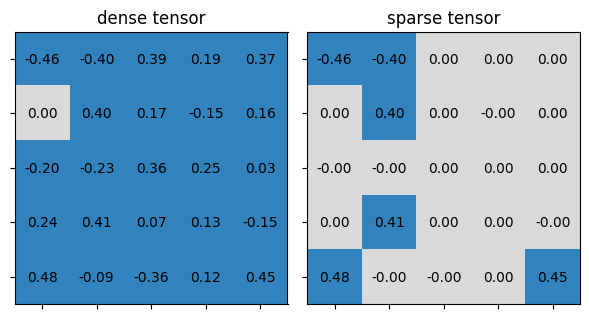

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [51]:
test_fine_grained_prune()

### Question 3 (5 pts)

ÎßàÏßÄÎßâ ÏÖÄÏùÄ pruning Ï†ÑÌõÑÏùò ÌÖêÏÑúÎ•º Í∑∏Î¶ΩÎãàÎã§. 0Ïù¥ ÏïÑÎãå Í∞íÏùÄ ÌååÎûÄÏÉâÏúºÎ°ú, 0ÏùÄ ÌöåÏÉâÏúºÎ°ú ÌëúÏãúÎê©ÎãàÎã§. Îã§Ïùå ÏΩîÎìú ÏÖÄÏóêÏÑú `target_sparsity`Ïùò Í∞íÏùÑ ÏàòÏ†ïÌïòÏó¨ pruning ÌõÑ sparse ÌÖêÏÑúÏóê 0Ïù¥ ÏïÑÎãå Í∞íÏù¥ 10Í∞úÎßå ÎÇ®ÎèÑÎ°ù Ìï¥ Ï£ºÏÑ∏Ïöî.

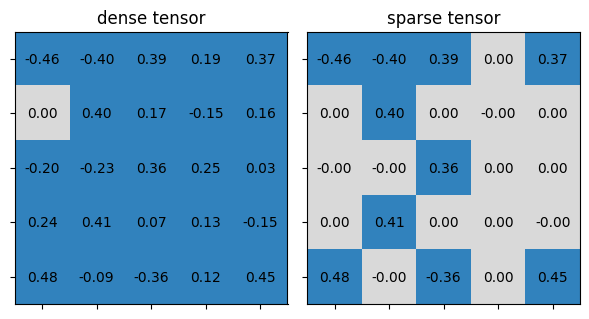

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [52]:
##################### YOUR CODE STARTS HERE #####################
# sparsity:=#Zeros/#ùëä=1‚àí#Nonzeros/#ùëä
# 1 - 10/25
target_sparsity = 0.6 # please modify the value of target_sparsit
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

Ïù¥Ï†ú fine-grained pruning Ìï®ÏàòÎ•º Ï†ÑÏ≤¥ Î™®Îç∏ÏùÑ pruningÌïòÎäî ÌÅ¥ÎûòÏä§Î°ú ÎûòÌïëÌï©ÎãàÎã§. `FineGrainedPruner` ÌÅ¥ÎûòÏä§ÏóêÏÑúÎäî Î™®Îç∏ Í∞ÄÏ§ëÏπòÍ∞Ä Î≥ÄÍ≤ΩÎê† ÎïåÎßàÎã§ ÎßàÏä§ÌÅ¨Î•º Ï†ÅÏö©ÌïòÏó¨ Î™®Îç∏Ïù¥ Ìï≠ÏÉÅ sparse ÏÉÅÌÉúÎ•º Ïú†ÏßÄÌï† Ïàò ÏûàÎèÑÎ°ù pruning ÎßàÏä§ÌÅ¨ Í∏∞Î°ùÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§.


In [53]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Í∞Å Î†àÏù¥Ïñ¥Îäî Î™®Îç∏ ÏÑ±Îä•Ïóê ÎåÄÌï¥ Í∞ÅÍ∞Å Îã§Î•¥Í≤å Í∏∞Ïó¨Ìï©ÎãàÎã§. Í∞Å Î†àÏù¥Ïñ¥Ïóê Ï†ÅÏ†àÌïú sparsityÎ•º Í≤∞Ï†ïÌïòÎäî Í≤ÉÏùÄ Ïñ¥Î†§Ïö¥ ÏùºÏûÖÎãàÎã§. ÎÑêÎ¶¨ ÏÇ¨Ïö©ÎêòÎäî Ï†ëÍ∑º Î∞©ÏãùÏùÄ **sensitivity scan**ÏûÖÎãàÎã§.

sensitivity scan ÎèôÏïà, Í∞Å ÏãúÍ∞ÑÎßàÎã§ **ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ÎßåÏùÑ prune**ÌïòÏó¨ accuracy Ï†ÄÌïòÎ•º Í¥ÄÏ∞∞Ìï©ÎãàÎã§. Îã§ÏñëÌïú sparsitiesÎ•º Ïä§Ï∫îÌï®ÏúºÎ°úÏç®, Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò sensitivity curve (Ï¶â, Ï†ïÌôïÎèÑ ÎåÄÎπÑ sparsity)Î•º Í∑∏Î¶¥ Ïàò ÏûàÏäµÎãàÎã§.

Îã§ÏùåÏùÄ **sensitivity curves**Ïùò ÏòàÏãú Í∑∏Î¶ºÏûÖÎãàÎã§. xÏ∂ïÏùÄ sparsity ÎòêÎäî #parametersÍ∞Ä Í∞êÏÜåÌïú ÎπÑÏú® (*Ï¶â*, sparsity)ÏûÖÎãàÎã§. yÏ∂ïÏùÄ Í≤ÄÏ¶ù Ï†ïÌôïÎèÑÏûÖÎãàÎã§. ([Learning both Weights and Connections for Efficient Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)Ïùò Figure 6)



![](https://github.com/TINYML-KOR/assignment/blob/main/images/lab1/sens_cur.png?raw=1)

Îã§Ïùå ÏΩîÎìú ÏÖÄÏùÄ Ïä§Ï∫îÎêú sparsitiesÏôÄ Í∞Å Í∞ÄÏ§ëÏπòÍ∞Ä pruneÎê† ÎïåÏùò Ï†ïÌôïÎèÑ Î¶¨Ïä§Ìä∏Î•º Î∞òÌôòÌïòÎäî sensitivity scan Ìï®ÏàòÎ•º Ï†ïÏùòÌï©ÎãàÎã§.

In [54]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Îã§Ïùå ÏÖÄÎì§ÏùÑ Ïã§ÌñâÌïòÏó¨ sensitivity curvesÎ•º Í∑∏Î†§Ï£ºÏÑ∏Ïöî. ÏôÑÎ£åÌïòÎäî Îç∞ ÏïΩ 2Î∂Ñ Ï†ïÎèÑ Í±∏Î¶¥ Í≤ÉÏûÖÎãàÎã§.


In [55]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

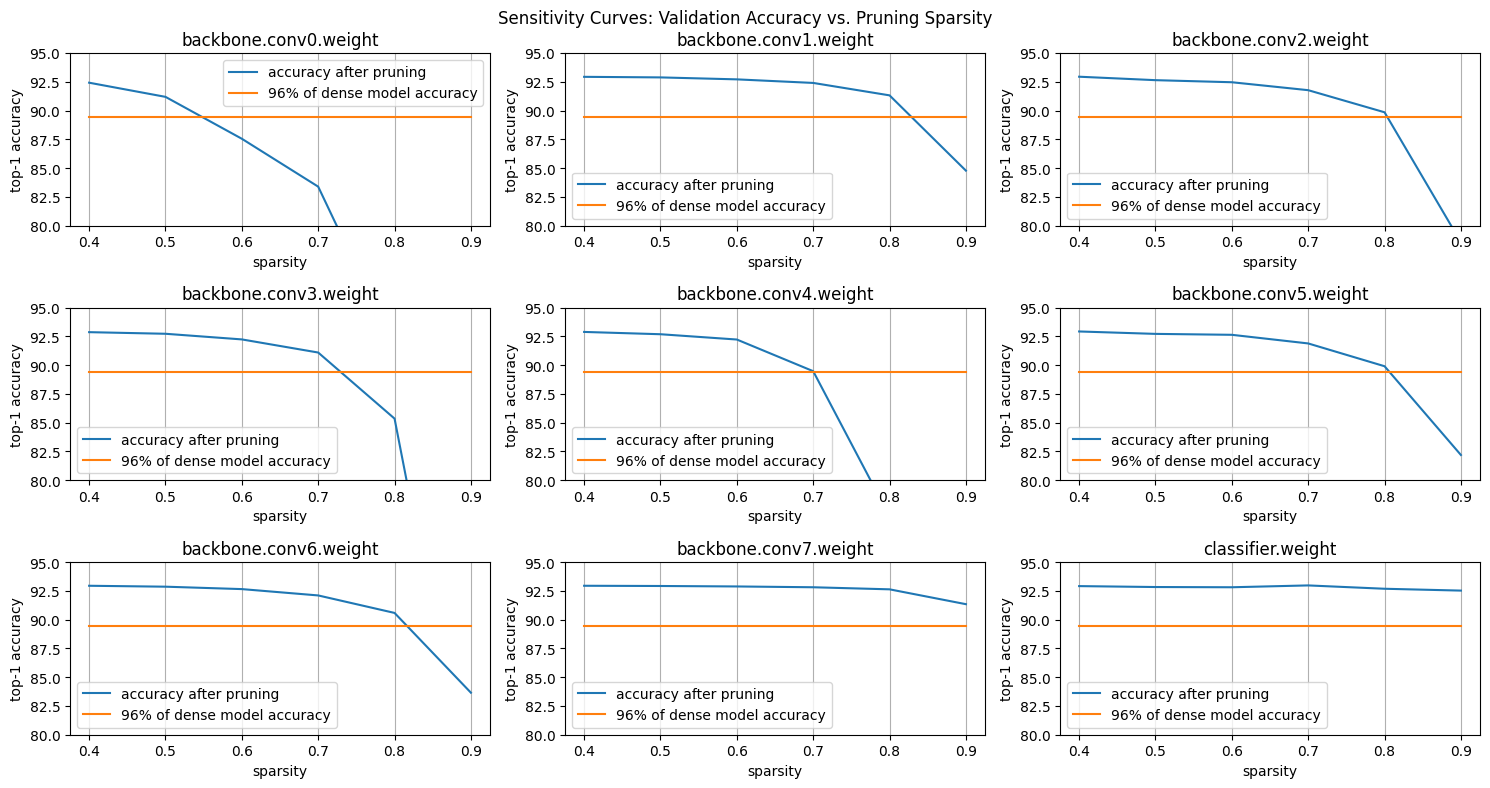

In [56]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### Question 4 (15 pts)

ÏúÑ sensitivity curvesÏùò Ï†ïÎ≥¥Î•º ÏÇ¨Ïö©ÌïòÏó¨ Îã§Ïùå ÏßàÎ¨∏Ïóê ÎãµÌï¥ Ï£ºÏÑ∏Ïöî.


#### Question 4.1 (5 pts)

pruning sparsityÏôÄ Î™®Îç∏ Ï†ïÌôïÎèÑ ÏÇ¨Ïù¥Ïùò Í¥ÄÍ≥ÑÎäî Î¨¥ÏóáÏù∏Í∞ÄÏöî? (*Ï¶â*, sparsityÍ∞Ä ÎÜíÏïÑÏßà Îïå Ï†ïÌôïÎèÑÍ∞Ä Ï¶ùÍ∞ÄÌïòÎÇòÏöî, ÏïÑÎãàÎ©¥ Í∞êÏÜåÌïòÎÇòÏöî?)

**Your Answer:**

pruning sparsityÍ∞Ä ÎÜíÏïÑÏßà ÏàòÎ°ù, model accuracyÎäî Í∞êÏÜåÌïòÎäî Í≤ΩÌñ•ÏùÑ Î≥¥Ïù∏Îã§

#### Question 4.2 (5 pts)

Î™®Îì† Î†àÏù¥Ïñ¥Í∞Ä Í∞ôÏùÄ sensitivityÎ•º Í∞ÄÏßÄÍ≥† ÏûàÎÇòÏöî?

**Your Answer:**


Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Îäî sensitiveÌïòÏßÄ ÏïäÍ≥†(classifier), Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Îäî sensitiveÌïòÎã§(conv0)
ÎåÄÏ≤¥Î°ú, ÏïûÏ™Ω Î†àÏù¥Ïñ¥(0~1..)Ïù¥ ÎØºÍ∞êÌï¥Î≥¥Ïù∏Îã§

#### Question 4.3 (5 pts)

Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Í∞Ä pruning sparsityÏóê Í∞ÄÏû• ÎØºÍ∞êÌïúÍ∞ÄÏöî?


**Your Answer:**


conv0 layer

## \#Parameters of each layer

Ï†ïÌôïÎèÑÎøêÎßå ÏïÑÎãàÎùº Í∞Å Î†àÏù¥Ïñ¥Ïùò Îß§Í∞úÎ≥ÄÏàò(parameter) ÏàòÎèÑ sparsity ÏÑ†ÌÉùÏóê ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ©ÎãàÎã§. **Îß§Í∞úÎ≥ÄÏàòÍ∞Ä Îçî ÎßéÏùÄ Î†àÏù¥Ïñ¥Îäî Îçî ÌÅ∞ sparsitiesÎ•º ÏöîÍµ¨Ìï©ÎãàÎã§.**

Îã§Ïùå ÏΩîÎìú ÏÖÄÏùÑ Ïã§ÌñâÌïòÏó¨ Ï†ÑÏ≤¥ Î™®Îç∏ÏóêÏÑú #parametersÏùò Î∂ÑÌè¨Î•º Í∑∏Î†§Ï£ºÏÑ∏Ïöî.

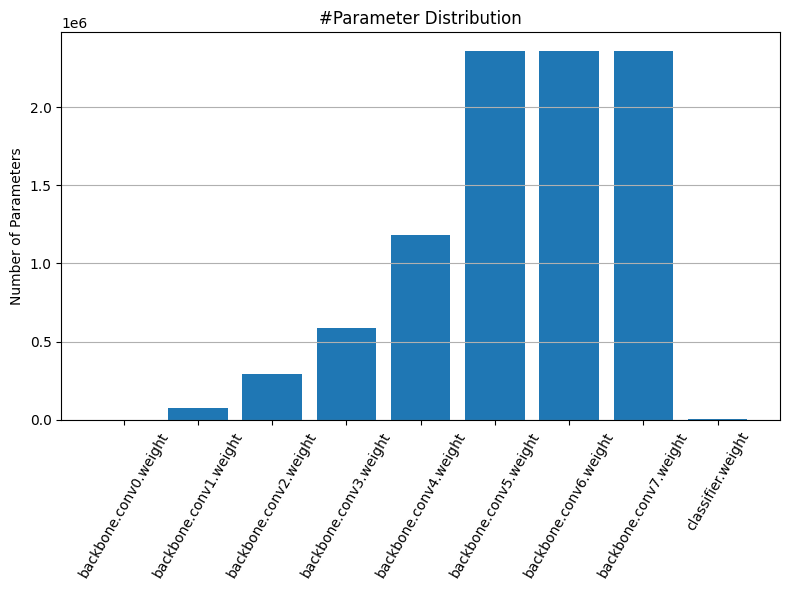

In [57]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## `Sensitivity Curves`ÏôÄ `#Parameters Î∂ÑÌè¨`Î•º Í∏∞Î∞òÏúºÎ°ú Sparsity ÏÑ†ÌÉùÌïòÍ∏∞



### Question 5 (10 pts)

sensitivity curvesÏôÄ Î™®Îç∏Ïùò `#parameters` Î∂ÑÌè¨Î•º Í∏∞Î∞òÏúºÎ°ú Í∞Å Î†àÏù¥Ïñ¥Ïùò sparsityÎ•º ÏÑ†ÌÉùÌï¥ Ï£ºÏÑ∏Ïöî.

pruned Î™®Îç∏Ïùò Ï†ÑÏ≤¥ ÏïïÏ∂ï ÎπÑÏú®ÏùÄ ÎåÄÏ≤¥Î°ú #parametersÍ∞Ä ÌÅ∞ Î†àÏù¥Ïñ¥Ïóê Ï£ºÎ°ú ÏùòÏ°¥ÌïòÎ©∞, Îã§Î•∏ Î†àÏù¥Ïñ¥Îäî pruningÏóê ÎåÄÌïú sensitivityÍ∞Ä Îã§Î¶ÖÎãàÎã§(Question 4 Ï∞∏Ï°∞).

pruning ÌõÑÏóê sparse Î™®Îç∏Ïù¥ dense Î™®Îç∏Ïùò ÌÅ¨Í∏∞Ïùò 25%Ïù¥Î©∞, finetuning ÌõÑÏóê Í≤ÄÏ¶ù Ï†ïÌôïÎèÑÍ∞Ä 92.5% Ïù¥ÏÉÅÏù∏ÏßÄ ÌôïÏù∏ÌïòÏÑ∏Ïöî.

**Hint**:

*   `#parameters`Í∞Ä Îçî ÎßéÏùÄ Î†àÏù¥Ïñ¥Îäî Îçî ÌÅ∞ sparsityÎ•º Í∞ÄÏ†∏Ïïº Ìï©ÎãàÎã§. (*Figure `#Parameter` Distribution* Ï∞∏Ï°∞)
*   pruning sparsityÏóê ÎØºÍ∞êÌïú Î†àÏù¥Ïñ¥(Ï¶â, sparsityÍ∞Ä ÎÜíÏïÑÏßàÏàòÎ°ù Ï†ïÌôïÎèÑÍ∞Ä Îπ†Î•¥Í≤å Îñ®Ïñ¥ÏßÄÎäî Î†àÏù¥Ïñ¥)Îäî Îçî ÏûëÏùÄ sparsityÎ•º Í∞ÄÏ†∏Ïïº Ìï©ÎãàÎã§. (*Figure Sensitivity Curves* Ï∞∏Ï°∞)


In [58]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0,
    'backbone.conv1.weight': 0.5,
    'backbone.conv2.weight': 0.5,
    'backbone.conv3.weight': 0.5,
    'backbone.conv4.weight': 0.5,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0
##################### YOUR CODE ENDS HERE #######################
}

Ï†ïÏùòÎêú `sparsity_dict`Ïóê Îî∞Îùº Î™®Îç∏ÏùÑ pruneÌïòÍ≥† sparse Î™®Îç∏Ïùò Ï†ïÎ≥¥Î•º Ï∂úÎ†•ÌïòÍ∏∞ ÏúÑÌï¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌï¥ Ï£ºÏÑ∏Ïöî.


After pruning with sparsity dictionary
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.50
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.50
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.00
The sparsity of each layer becomes
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.50
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.50
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.00
Sparse model has size=8.63 MiB = 24.50% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=87.00% before fintuning


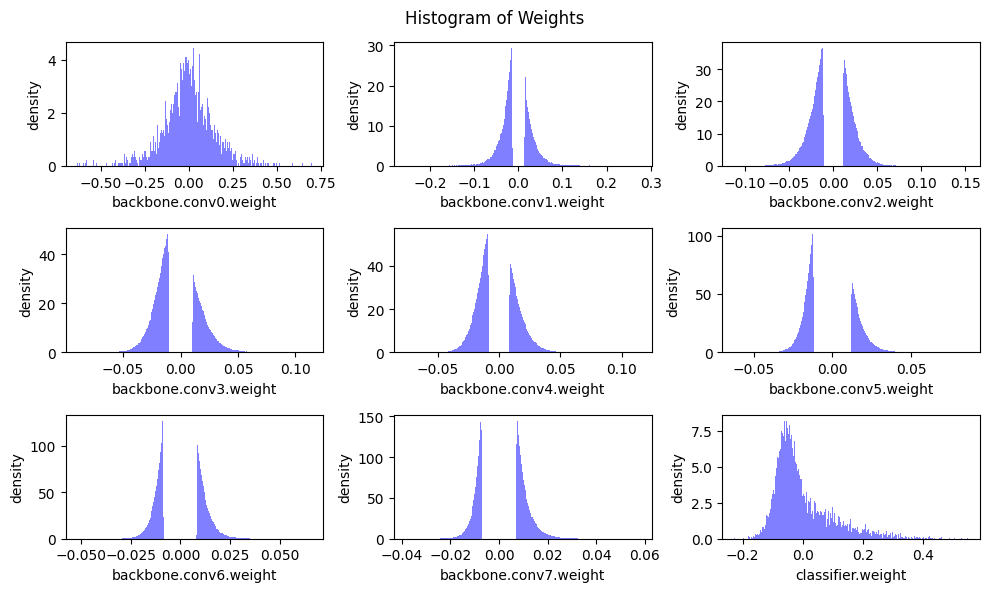

In [59]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

Ïù¥Ï†Ñ ÏÖÄÏùò Ï∂úÎ†•ÏóêÏÑú Î≥º Ïàò ÏûàÎìØÏù¥, **fine-grained pruningÏù¥ Î™®Îç∏ Í∞ÄÏ§ëÏπòÏùò ÎåÄÎ∂ÄÎ∂ÑÏùÑ Ï§ÑÏù¥ÏßÄÎßå Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÎèÑ Îñ®Ïñ¥Ï°åÏäµÎãàÎã§.** Îî∞ÎùºÏÑú, sparse Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÎ•º ÌöåÎ≥µÌïòÍ∏∞ ÏúÑÌï¥ **finetuneÌï¥Ïïº Ìï©ÎãàÎã§.**

sparse Î™®Îç∏ÏùÑ finetuneÌïòÍ∏∞ ÏúÑÌï¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌï¥ Ï£ºÏÑ∏Ïöî. ÏôÑÎ£åÌïòÎäî Îç∞ ÏïΩ 3Î∂Ñ Ï†ïÎèÑ Í±∏Î¶¥ Í≤ÉÏûÖÎãàÎã§.


In [60]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.66% / Best Accuracy: 92.66%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.77% / Best Accuracy: 92.77%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.80% / Best Accuracy: 92.80%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.68% / Best Accuracy: 92.80%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.77% / Best Accuracy: 92.80%


best finetuned sparse Î™®Îç∏Ïùò Ï†ïÎ≥¥Î•º Î≥¥Í∏∞ ÏúÑÌï¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌï¥ Ï£ºÏÑ∏Ïöî.

In [61]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=8.63 MiB = 24.50% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.80% after fintuning


# Channel Pruning

Ïù¥ ÏÑπÏÖòÏóêÏÑúÎäî **channel pruning**ÏùÑ Íµ¨ÌòÑÌï† Í≤ÉÏûÖÎãàÎã§. Channel pruningÏùÄ Ï†ÑÏ≤¥ Ï±ÑÎÑêÏùÑ Ï†úÍ±∞ÌïòÏó¨ Í∏∞Ï°¥ ÌïòÎìúÏõ®Ïñ¥(Ïòà: GPU)ÏóêÏÑú Ï∂îÎ°† ÏÜçÎèÑÎ•º Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§. ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú, **Îçî ÏûëÏùÄ ÌÅ¨Í∏∞(Frobenius normÏúºÎ°ú Ï∏°Ï†ï)Ïùò Í∞ÄÏ§ëÏπòÎ•º Í∞ÄÏßÑ Ï±ÑÎÑêÏùÑ Ï†úÍ±∞**Ìï©ÎãàÎã§.


In [62]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## Remove Channel Weights


Fine-grained pruningÍ≥º Îã¨Î¶¨, channel pruningÏóêÏÑúÎäî ÌÖêÏÑúÏóêÏÑú Í∞ÄÏ§ëÏπòÎ•º ÏôÑÏ†ÑÌûà Ï†úÍ±∞Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ï¶â, Ï∂úÎ†• Ï±ÑÎÑêÏùò ÏàòÍ∞Ä Ï§ÑÏñ¥Îì≠ÎãàÎã§:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

Channel pruning ÌõÑÏóêÎèÑ Í∞ÄÏ§ëÏπò ÌÖêÏÑú $W$Îäî Ïó¨Ï†ÑÌûà denseÌï©ÎãàÎã§. Îî∞ÎùºÏÑú, *sparsity*Î•º ***prune ratio***ÎùºÍ≥† Ìï©ÎãàÎã§.

Fine-grained pruningÏ≤òÎüº, Îã§Î•∏ Î†àÏù¥Ïñ¥Ïóê ÎåÄÌï¥ Îã§Î•∏ pruning ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÌïòÏßÄÎßå ÏßÄÍ∏àÏùÄ Î™®Îì† Î†àÏù¥Ïñ¥Ïóê ÎåÄÌï¥ **Í∑†ÏùºÌïú pruning ÎπÑÏú®ÏùÑ ÏÇ¨Ïö©**Ìï©ÎãàÎã§. Ïö∞Î¶¨Îäî ÎåÄÎûµ 30%Ïùò Í∑†ÏùºÌïú pruning ÎπÑÏú®Î°ú 2Î∞∞Ïùò Í≥ÑÏÇ∞ Í∞êÏÜåÎ•º Î™©ÌëúÎ°ú Ìï©ÎãàÎã§(Ïôú Í∑∏Îü∞ÏßÄ ÏÉùÍ∞ÅÌï¥ Î≥¥ÏÑ∏Ïöî).

Ïù¥ ÏÑπÏÖòÏùò ÎÅùÏóêÏÑú Î†àÏù¥Ïñ¥Î≥ÑÎ°ú Îã§Î•∏ pruning ÎπÑÏú®ÏùÑ ÏãúÎèÑÌï¥ Î≥º Ïàò ÏûàÏäµÎãàÎã§. `channel_prune` Ìï®ÏàòÏóê ÎπÑÏú® Î¶¨Ïä§Ìä∏Î•º Ï†ÑÎã¨Ìï† Ïàò ÏûàÏäµÎãàÎã§.



### Question 6 (10 pts)

Channel pruningÏùÑ ÏúÑÌïú Îã§Ïùå Ìï®ÏàòÎ•º ÏôÑÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî.

Ïó¨Í∏∞ÏÑú Ïö∞Î¶¨Îäî Ï≤´ Î≤àÏß∏ $\#\mathrm{out\_channels}_{\mathrm{new}}$ Ï±ÑÎÑêÏùÑ Ï†úÏô∏Ìïú Î™®Îì† Ï∂úÎ†• Ï±ÑÎÑêÏùÑ Îã®ÏàúÌûà pruneÌï©ÎãàÎã§.

In [63]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round((1-prune_ratio)*channels))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


Íµ¨ÌòÑÏù¥ Ïò¨Î∞îÎ•∏ÏßÄ ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌï¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌïòÏó¨ ÌôïÏù∏ÌïòÏÑ∏Ïöî.

In [64]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


Ïù¥Ï†ú 30% pruning ÎπÑÏú®ÏùÑ Í∞ÄÏßÑ Í∑†Ïùº channel pruning ÌõÑ Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï¥ Î¥ÖÏãúÎã§.

ÏßÅÏ†ëÏ†ÅÏúºÎ°ú 30%Ïùò Ï±ÑÎÑêÏùÑ Ï†úÍ±∞ÌïòÎäî Í≤ÉÏùÄ ÎÇÆÏùÄ Ï†ïÌôïÎèÑÎ°ú Ïù¥Ïñ¥ÏßëÎãàÎã§.


In [65]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%


## Ranking Channels by Importance

Î≥¥ÏãúÎã§ÏãúÌîº, Î™®Îì† Î†àÏù¥Ïñ¥ÏóêÏÑú Ï≤´ 30%Ïùò Ï±ÑÎÑêÏùÑ Ï†úÍ±∞ÌïòÎ©¥ Ï†ïÌôïÎèÑÍ∞Ä ÌÅ¨Í≤å Í∞êÏÜåÌï©ÎãàÎã§. Ïù¥ Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÎäî Ìïú Í∞ÄÏßÄ Í∞ÄÎä•Ìïú Î∞©Î≤ïÏùÄ **Îçú Ï§ëÏöîÌïú** Ï±ÑÎÑê Í∞ÄÏ§ëÏπòÎ•º Ï∞æÏïÑÏÑú Ï†úÍ±∞ÌïòÎäî Í≤ÉÏûÖÎãàÎã§. Ï§ëÏöîÎèÑÎ•º ÌèâÍ∞ÄÌïòÎäî Ïù∏Í∏∞ ÏûàÎäî Í∏∞Ï§ÄÏùÄ Í∞Å ÏûÖÎ†• Ï±ÑÎÑêÏóê Ìï¥ÎãπÌïòÎäî Í∞ÄÏ§ëÏπòÏùò Frobenius normÏùÑ ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏûÖÎãàÎã§:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

Ïö∞Î¶¨Îäî Ï±ÑÎÑê Í∞ÄÏ§ëÏπòÎ•º Îçî Ï§ëÏöîÌïú Í≤ÉÏóêÏÑú Îçú Ï§ëÏöîÌïú Í≤ÉÏúºÎ°ú Ï†ïÎ†¨Ìïú Îã§Ïùå, Í∞Å Î†àÏù¥Ïñ¥Ïóê ÎåÄÌï¥ Ï≤òÏùå $k$Í∞úÏùò Ï±ÑÎÑêÏùÑ Ïú†ÏßÄÌï† Ïàò ÏûàÏäµÎãàÎã§.


### Question 7 (15 pts)


Frobenius normÏóê Í∏∞Î∞òÌïòÏó¨ Í∞ÄÏ§ëÏπò ÌÖêÏÑúÎ•º Ï†ïÎ†¨ÌïòÎäî Îã§Ïùå Ìï®ÏàòÎ•º ÏôÑÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî.

**Hint**:


* ÌÖêÏÑúÏùò Frobenius normÏùÑ Í≥ÑÏÇ∞ÌïòÍ∏∞ ÏúÑÌï¥, PytorchÎäî [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIÎ•º Ï†úÍ≥µÌï©ÎãàÎã§.


In [66]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight, p=2)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Ïù¥Ï†ú Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌïòÏó¨ Í≤∞Í≥ºÍ∞Ä Ïò¨Î∞îÎ•∏ÏßÄ ÌôïÏù∏ÌïòÏÑ∏Ïöî.


In [67]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


ÎßàÏßÄÎßâÏúºÎ°ú ÌîÑÎ£®ÎãùÎêú Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÎ•º Ï†ïÎ†¨Ìï† ÎïåÏôÄ Í∑∏Î†áÏßÄ ÏïäÏùÑ ÎïåÎ•º ÎπÑÍµêÌï©ÎãàÎã§.

In [68]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


Î≥¥ÏãúÎã§ÏãúÌîº channel sortingÏùÄ pruned modelÏùò Ï†ïÌôïÎèÑÎ•º ÏïΩÍ∞Ñ Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏßÄÎßå Ïó¨Ï†ÑÌûà channel pruningÏóê Îß§Ïö∞ ÏùºÎ∞òÏ†ÅÏù∏ ÌÅ∞ Ï†ÄÌïòÍ∞Ä ÏûàÎäî Í±∏ Ïïå Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Îü¨Ìïú Ï†ïÌôïÎèÑ Ï†ÄÌïòÎ•º ÌöåÎ≥µÌïòÍ∏∞ ÏúÑÌï¥ fine-tuningÏùÑ ÏàòÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.

In [69]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.66% / Best Accuracy: 91.66%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 92.10% / Best Accuracy: 92.10%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.01% / Best Accuracy: 92.10%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.18% / Best Accuracy: 92.18%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.16% / Best Accuracy: 92.18%


## Measure acceleration from pruning

fine-tuningÏù¥ ÎÅùÎÇòÎ©¥ Î™®Îç∏ÏùÄ Ï†ïÌôïÎèÑÎ•º Í±∞Ïùò ÌöåÎ≥µÌï©ÎãàÎã§. channel pruningÎäî fine-grained pruningÏóê ÎπÑÌï¥ ÏùºÎ∞òÏ†ÅÏúºÎ°ú Ï†ïÌôïÎèÑÎ•º ÌöåÎ≥µÌïòÍ∏∞Í∞Ä Îçî Ïñ¥Î†µÎã§Îäî Í≤ÉÏùÑ Ïù¥ÎØ∏ ÏïåÍ≥† Í≥ÑÏã§ ÏàòÎèÑ ÏûàÏäµÎãàÎã§. Í∑∏Îü¨ÎÇò specialized model formatÏù¥ ÏóÜÏúºÎ©¥ ÏßÅÏ†ëÏ†ÅÏúºÎ°ú Î™®Îç∏ ÌÅ¨Í∏∞Í∞Ä ÏûëÏïÑÏßÄÍ≥† Í≥ÑÏÇ∞Ïù¥ ÏûëÏïÑÏßëÎãàÎã§. GPUÏóêÏÑúÎèÑ Îçî Îπ†Î•¥Í≤å Ïã§ÌñâÎê† Ïàò ÏûàÏäµÎãàÎã§.

Ïù¥Ï†ú pruned modelÏùò Î™®Îç∏ ÌÅ¨Í∏∞, Í≥ÑÏÇ∞ Î∞è ÏßÄÏó∞ ÏãúÍ∞ÑÏùÑ ÎπÑÍµêÌï¥Î¥ÖÏãúÎã§.

In [70]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    24.2            13.0            1.9            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


### Question 8 (10 pts)

Ïù¥Ï†Ñ ÏΩîÎìúÏÖÄÏùò Ï†ïÎ≥¥Î•º Ïù¥Ïö©ÌïòÏó¨ Îã§Ïùå ÏßàÎ¨∏Ïóê ÎãµÎ≥ÄÌï¥ Ï£ºÏãúÍ∏∞ Î∞îÎûçÎãàÎã§.


#### Question 8.1 (5 pts)

30%Ïùò Ï±ÑÎÑêÏùÑ Ï†úÍ±∞ÌïòÎ©¥ ÎåÄÎûµ 50%Ïùò Í≥ÑÏÇ∞ Ï†àÍ∞ê Ìö®Í≥ºÍ∞Ä Î∞úÏÉùÌïòÎäî Ïù¥Ïú†Î•º ÏÑ§Î™ÖÌïòÏÑ∏Ïöî.

**Your Answer:**

MACÏùÄ 2Î∞∞, ParamÏùÄ 1.8Î∞∞ Ï§ÑÏñ¥Îì§ÏóàÏßÄÎßå, latencyÎäî 1.7Î∞∞Îßå Îçî Îπ®ÎùºÏ°åÎã§
Î©îÎ™®Î¶¨ Í¥ÄÎ†®Îêú Ïù¥Ïú†ÎùºÍ≥† Ï∂îÏ†ïÎê®

#### Question 8.2 (5 pts)

ÏßÄÏó∞ ÏãúÍ∞Ñ Í∞êÏÜå ÎπÑÏú®(latency reduction ratio)Ïù¥ Í≥ÑÏÇ∞ Í∞êÏÜå(computation reduction)Î≥¥Îã§ ÏïΩÍ∞Ñ ÏûëÏùÄ Ïù¥Ïú†Î•º ÏÑ§Î™ÖÌïòÏÑ∏Ïöî.

**Your Answer:**


0.7^2 = 0.49 ÎãàÍπå, ÏñºÏ∂î 2Î∞∞. ÌååÎùºÎØ∏ÌÑ∞ ÏàòÍ∞Ä Ï§ÑÏñ¥Îì§ÏàòÎ°ù latencyÎäî quadraticÌïòÍ≤å Ï§ÑÏñ¥Îì†Îã§

---



# Compare Fine-grained Pruning and Channel Pruning


## Question 9 (10 pts)


Ïù¥Î≤à Îû©ÏóêÏÑú Î™®Îì† Ïã§ÌóòÏùÑ Ìïú ÌõÑÏóêÎäî fine-grained pruningÏôÄ channel pruningÏóê ÏùµÏàôÌï¥Ïßà Ïàò ÏûàÏäµÎãàÎã§.

lectureÏôÄ Ïù¥Î≤à labÏóêÏÑú Î∞∞Ïö¥ ÎÇ¥Ïö©ÏùÑ ÌôúÏö©ÌïòÏó¨ Îã§Ïùå ÏßàÎ¨∏Ïóê ÎãµÎ≥ÄÌï¥ Ï£ºÏãúÍ∏∞ Î∞îÎûçÎãàÎã§.

### Question 9.1 (5 pts)

fine-grained pruningÏôÄ channel pruningÏùò Ïû•Îã®Ï†êÏùÄ Î¨¥ÏóáÏûÖÎãàÍπå?

compression ratio, accuracy, latency, hardware support(*i.e.*, Ï†ÑÎ¨∏ ÌïòÎìúÏõ®Ïñ¥ Í∞ÄÏÜçÍ∏∞ ÌïÑÏöî) Îì±Ïùò Í¥ÄÏ†êÏóêÏÑú ÎÖºÏùòÌï† Ïàò ÏûàÏäµÎãàÎã§.

**Your Answer:**

fine-grained

Ïû•Ï†ê
- Ï†ïÌôïÎèÑÍ∞Ä ÎÜíÏùå
- Usually larger compression ratio since we can
fl
exibly
fi
nd ‚Äúredundant‚Äù weights

Îã®Ï†ê
- cpu overhead
- memory overhead
- hardware support ÌïÑÏöî(eie...)

channel pruning
Ïû•Ï†ê
- Îπ†Î•∏ inference

Îã®Ï†ê
- smaller compression ratio

### Question 9.2 (5 pts)

Ïä§ÎßàÌä∏Ìè∞ÏóêÏÑú Î™®Îç∏ÏùÑ Îçî Îπ®Î¶¨ Ïã§ÌñâÏãúÌÇ§Í≥† Ïã∂Îã§Î©¥, Ïñ¥Îñ§ Í∞ÄÏßÄÏπòÍ∏∞ Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï† Í≤ÉÏù∏Í∞ÄÏöî? Í∑∏ Ïù¥Ïú†Îäî Î¨¥ÏóáÏù∏Í∞ÄÏöî?

**Your Answer:**

ÌäπÎ≥ÑÌïú ÌïòÎìúÏõ®Ïñ¥ ÏÑúÌè¨Ìä∏Í∞Ä ÌïÑÏöîÌïòÏßÄÏïäÍ≥†, inference timeÏù¥ Îπ†Î•∏ channel pruning.

# Feedback

Please fill out this [feedback form](https://forms.gle/fapEmEUYr3WnXjBU8) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!